manuscript\11Q10-627-1.jpg
Bounding Box Coordinates:  (5314, 5363, 5345, 5394)
manuscript\11Q10-628-1.jpg
Bounding Box Coordinates:  (-10, -10, 5432, 7236)
manuscript\11Q10-628-2.jpg
Bounding Box Coordinates:  (-10, -10, 5432, 7236)
manuscript\11Q10-632-1.jpg
Bounding Box Coordinates:  (-10, -10, 5432, 7236)
manuscript\11Q10-633-1.jpg
Bounding Box Coordinates:  (-10, -10, 5432, 7236)
manuscript\11Q10-633-2.jpg
Bounding Box Coordinates:  (-10, -10, 5432, 7236)
manuscript\11Q10-637-1.jpg
Bounding Box Coordinates:  (5153, 5286, 5184, 5318)
manuscript\11Q10-637-2.jpg
Bounding Box Coordinates:  (-10, -10, 5432, 7236)
manuscript\4Q284-239-3.jpg
Bounding Box Coordinates:  (49, 923, 2727, 3389)
manuscript\4Q502-3-4.jpg
Bounding Box Coordinates:  (112, 163, 3136, 2229)


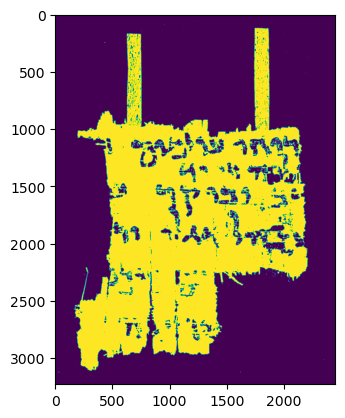

In [2]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import os
import csv

fragments_data_path = "manuscript"                      # Declare image folder
output1 = "Images.txt"
output2 = "BBCords.txt"
output3 = "BBCords.csv"                                 # Declare CSV output file.
header = ["manuscript-parchment-fragment","BBCords"]
data = []

def convertTuple(tup):
    # Initialize an empty string
    string = '('
    for item in tup:
        string = string + str(item) + ', '
    string = string[:-2]
    string = string + ')'
    return string

for image_name in os.listdir(fragments_data_path):
    # Read the image in color using OpenCV
    image = cv2.imread(fragments_data_path + chr(92) + image_name, cv2.IMREAD_COLOR)
    print(fragments_data_path + chr(92) + image_name)
    with open(output1, 'a') as n:
        n.write(image_name + '\n')

    # Convert the image to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Extract the a and b layers from the LAB image
    a_channel, b_channel, _ = cv2.split(lab_image)

    # Take the absolute values of a_channel and b_channel
    a_channel = np.abs(a_channel)
    b_channel = np.abs(b_channel)

    # Reshape the a and b channels into a 2D array for clustering
    ab_channels = np.column_stack((a_channel.flatten(), b_channel.flatten()))

    # Cluster the a and b layer values into 2 clusters using K-means
    kmeans = KMeans(n_clusters=2, random_state=42)
    cluster_labels = kmeans.fit_predict(ab_channels)

    # Calculate the image center coordinates
    height, width = image.shape[:2]
    center_x, center_y = int(width / 2), int(height / 2)

    # Calculate the center area coordinates (adjust the size as needed)
    center_size = 100  # Adjust this value based on the desired center area size
    center_left = center_x - int(center_size / 2)
    center_right = center_x + int(center_size / 2)
    center_top = center_y - int(center_size / 2)
    center_bottom = center_y + int(center_size / 2)

    # Reshape cluster_labels into the shape of the image
    cluster_labels = cluster_labels.reshape(a_channel.shape)

    # Extract the cluster labels within the center region
    center_labels = cluster_labels[center_top:center_bottom, center_left:center_right]

    # Find the unique labels and their counts within the center region
    unique_labels, label_counts = np.unique(center_labels, return_counts=True)

    # Find the cluster label with the most pixels in the center region
    fragment_cluster_label = unique_labels[np.argmax(label_counts)]

    # Create a binary mask for pixels belonging to the fragment cluster
    binary_mask = (cluster_labels == fragment_cluster_label).astype(np.uint8) * 255
    plt.imshow(binary_mask)

    # Label connected components in the binary mask
    labelled_mask, num_labels = label(binary_mask, connectivity=2, return_num=True)

    # Find the properties of connected components
    props = regionprops(labelled_mask)

    # Find the index of the connected component that contains the center pixel
    center_y, center_x = int(binary_mask.shape[0] / 2), int(binary_mask.shape[1] / 2)
    component_index = labelled_mask[center_y, center_x]

    # Find the properties of the connected component that contains the center pixel
    component_props = props[component_index - 1]  # Subtract 1 to account for 0-based indexing

    # Get the bounding box coordinates of the connected component
    bbox = component_props.bbox

    padding_size = 10

    # Add padding to the bounding box coordinates
    bbox_padded = (bbox[0] - padding_size, bbox[1] - padding_size, bbox[2] + 2 * padding_size, bbox[3] + 2 * padding_size)

    print("Bounding Box Coordinates: ", bbox_padded)
    with open(output2, 'a') as n:
        string = convertTuple(bbox_padded)
        n.write(string + '\n')
    image_name = image_name[:-4]
    data = data + [[image_name, bbox_padded]]
    with open(output3, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)

        # write the header
        writer.writerow(header)

        # write multiple rows
        writer.writerows(data)

